# Space Weather Forecast Notebook

This notebook is used for debugging and experimenting with the PatchTST model for forecasting space weather indices (ap_index_nT and f10.7_index).

We will load and preprocess the data, define our model and dataset, and then run training and evaluation functions. Use the controls below to run or skip certain sections (e.g., if you only want to debug data preprocessing).


In [1]:
import argparse
import logging
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import matplotlib.pyplot as plt
from tqdm import tqdm  # Make sure you have tqdm installed
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set up logging with a default INFO level.
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)
logger = logging.getLogger(__name__)

# For notebook usage, you might want to display plots inline.
%matplotlib inline


## 1. Define the PatchTST-inspired Model

The model takes a time series input, "patchifies" it using a 1D convolution, passes it through Transformer encoder layers, and finally outputs a forecast for the target features. We set `batch_first=True` to simplify the input shapes.


In [2]:
class PatchTST(nn.Module):
    """
    A simplified PatchTST model.
    This model "patchifies" the input time series with a 1D convolution,
    processes the patches with Transformer encoder layers, and then outputs
    a forecast for a fixed horizon.
    """
    def __init__(self, input_size, patch_size, d_model, n_heads, n_layers, 
                 forecast_horizon, target_size, dropout=0.1):
        super(PatchTST, self).__init__()
        self.input_size = input_size
        self.patch_size = patch_size
        self.d_model = d_model
        self.forecast_horizon = forecast_horizon  # For reshaping output
        self.target_size = target_size            # For reshaping output

        logger.debug("Initializing PatchTST model.")
        # Patchify the time series along the time axis.
        self.proj = nn.Conv1d(in_channels=input_size, out_channels=d_model,
                              kernel_size=patch_size, stride=patch_size)
        # Use batch_first=True for the Transformer layers.
        encoder_layers = TransformerEncoderLayer(d_model, n_heads, d_model * 4, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, n_layers)
        # Forecast head outputs forecast_horizon steps for each target feature.
        self.fc = nn.Linear(d_model, forecast_horizon * target_size)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch, seq_len, input_size)
        Returns:
            Tensor of shape (batch, forecast_horizon, target_size)
        """
        batch_size = x.size(0)
        # Conv1d expects (batch, input_size, seq_len)
        x = x.transpose(1, 2)
        x = self.proj(x)       # (batch, d_model, new_seq_len)
        x = x.transpose(1, 2)  # (batch, new_seq_len, d_model)
        x = self.transformer_encoder(x)  # (batch, new_seq_len, d_model)
        # Use the last patch's representation
        x_last = x[:, -1, :]
        out = self.fc(x_last)
        out = out.view(batch_size, self.forecast_horizon, self.target_size)
        return out


## 2. Define Dataset and DataHandler

The `TimeSeriesDataset` class creates sliding window examples.  
The `DataHandler` class loads OMNI and sat density files based on an initial state file.


In [3]:
class TimeSeriesDataset(data.Dataset):
    """
    Creates sliding-window examples from the full time series.
    Each sample is a tuple (x, y) where:
      - x: a window of input features (length = input_window)
      - y: the next forecast_horizon values for the target features.
    """
    def __init__(self, X, Y, input_window, forecast_horizon):
        self.X = X
        self.Y = Y
        self.input_window = input_window
        self.forecast_horizon = forecast_horizon
        self.length = len(X) - input_window - forecast_horizon + 1
        logger.debug(f"TimeSeriesDataset initialized with {self.length} samples.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = self.X[idx : idx + self.input_window]
        y = self.Y[idx + self.input_window : idx + self.input_window + self.forecast_horizon]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class DataHandler():
    def __init__(self, omni_folder, initial_state_folder, sat_density_folder, forcasted_omni2_data_folder):
        self.omni_folder = omni_folder
        self.initial_state_folder = initial_state_folder
        self.sat_density_folder = sat_density_folder
        self.forcasted_omni2_data_folder = forcasted_omni2_data_folder
        self.__read_initial_states()

    def __read_initial_states(self):
        all_dataframes = []
        for file in self.initial_state_folder.iterdir():
            if file.suffix == '.csv':
                df = pd.read_csv(file)
                all_dataframes.append(df)
        self.initial_states = pd.concat(all_dataframes, ignore_index=True)
        logger.info(f"Loaded initial state data with {len(self.initial_states)} rows.")

    def read_omni_data(self, file_id):
        file_id_str = f"{file_id:05d}"
        for file in self.omni_folder.iterdir():
            if file.suffix == '.csv' and file_id_str in file.stem:
                logger.debug(f"Reading OMNI file for File ID {file_id}.")
                return pd.read_csv(file)
        raise FileNotFoundError(f"File with ID {file_id} not found in {self.omni_folder}")

    def read_sat_density_data(self, file_id):
        file_id_str = f"{file_id:05d}"
        for file in self.sat_density_folder.iterdir():
            if file.suffix == '.csv' and file_id_str in file.stem:
                logger.debug(f"Reading Sat density file for File ID {file_id}.")
                return pd.read_csv(file)
        raise FileNotFoundError(f"File with ID {file_id} not found in {self.sat_density_folder}")


## 3. Training, Evaluation, and Forecasting Functions

This cell contains the training loop (with progress reporting via `tqdm`), evaluation functions, and a helper function for forecasting.


In [4]:
def train_model(model, train_loader, val_loader, epochs, lr, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.to(device)
    logger.info("Starting training loop.")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_pbar = tqdm(enumerate(train_loader), total=len(train_loader),
                          desc=f"Epoch {epoch+1}/{epochs} Training", unit="batch")
        for batch_idx, (x, y) in train_pbar:
            # Check for NaNs in inputs
            if torch.isnan(x).any():
                logger.error(f"Input batch contains NaNs. Batch {batch_idx} at epoch {epoch+1}")
            if torch.isnan(y).any():
                logger.error(f"Target batch contains NaNs. Batch {batch_idx} at epoch {epoch+1}")

            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            if torch.isnan(loss):
                logger.error(f"Loss is NaN at epoch {epoch+1}, batch {batch_idx}. Aborting training.")
                return
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            train_pbar.set_postfix(loss=f"{loss.item():.6f}")
        
        train_loss /= len(train_loader.dataset)
        logger.info(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")

        model.eval()
        val_loss = 0.0
        val_pbar = tqdm(enumerate(val_loader), total=len(val_loader),
                        desc=f"Epoch {epoch+1}/{epochs} Validation", unit="batch")
        with torch.no_grad():
            for batch_idx, (x, y) in val_pbar:
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = criterion(output, y)
                val_loss += loss.item() * x.size(0)
                val_pbar.set_postfix(loss=f"{loss.item():.6f}")
        val_loss /= len(val_loader.dataset)
        logger.info(f"Epoch {epoch+1}/{epochs}, Val Loss: {val_loss:.6f}")

def evaluate_model(model, test_loader, device):
    model.eval()
    mse_sum = 0.0
    mae_sum = 0.0
    total_elements = 0
    all_preds = []
    all_trues = []
    criterion = nn.MSELoss(reduction='sum')
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            all_preds.append(preds.cpu())
            all_trues.append(y.cpu())
            mse_sum += criterion(preds, y).item()
            mae_sum += torch.sum(torch.abs(preds - y)).item()
            total_elements += y.numel()
    mse_avg = mse_sum / total_elements
    mae_avg = mae_sum / total_elements
    all_preds = torch.cat(all_preds, dim=0)
    all_trues = torch.cat(all_trues, dim=0)
    logger.info(f"Evaluation complete: MSE={mse_avg:.6f}, MAE={mae_avg:.6f}")
    return mse_avg, mae_avg, all_preds, all_trues

def forecast(model, input_sequence, device):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_sequence, dtype=torch.float32).unsqueeze(0).to(device)
        output = model(input_tensor)
    return output.squeeze(0).cpu().numpy()

def plot_combined_forecast(history_timestamps, history_values, forecast_timestamps, forecast_values, 
                           ylabel, title, true_forecast=None):
    """
    Plot a combined time series showing historical data and forecasted values.
    Optionally, also plot true forecast values in the background.
    
    Args:
        history_timestamps (array-like): Timestamps for historical data.
        history_values (array-like): Historical target values.
        forecast_timestamps (array-like): Timestamps for forecasted data.
        forecast_values (array-like): Forecasted target values.
        ylabel (str): Label for the Y-axis.
        title (str): Plot title.
        true_forecast (array-like, optional): True forecast values.
    """
    logger.debug("Plotting combined forecast.")
    plt.figure(figsize=(12, 6))
    
    # Plot true forecast first (background)
    if true_forecast is not None:
        plt.plot(forecast_timestamps, true_forecast, 
                 label="True Forecast", marker='o', linestyle='--', color='green', 
                 zorder=1, alpha=0.5)
    
    # Plot historical and predicted forecast on top (foreground)
    plt.plot(history_timestamps, history_values, label="Historical", marker='o', color='blue', zorder=2)
    plt.plot(forecast_timestamps, forecast_values, label="Forecast", marker='x', color='red', zorder=2)
    
    plt.xlabel("Timestamp")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    
    # Use a DateFormatter to show full timestamp with hour, minute, and second.
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    
    plt.legend()
    plt.tight_layout()
    plt.show()


## 4. Data Loading, Preprocessing, and Feature Selection

In this section, we:
- Set folder paths and load the data using `DataHandler`.
- Load a subset (using `load_percentage`) for faster debugging.
- Preprocess the data: convert timestamps, sort, and select only the suggested candidate features.
- Remove any features that are all NaN or constant.
- Fill any remaining NaNs with the median and normalize the input features.


In [5]:
# Set folder paths (adjust as needed)
omni_folder = Path("./data/omni2")
initial_state_folder = Path("./data/initial_state")
sat_density_folder = Path("./data/sat_density")
forcasted_omni2_data_folder = Path("./data/forcasted_omni2")

# Instantiate DataHandler.
data_handler = DataHandler(omni_folder, initial_state_folder, sat_density_folder, forcasted_omni2_data_folder)

# Load all files based on initial_states File ID.
load_percentage = 0.01  # For testing, load only 1% of file IDs.

file_ids = data_handler.initial_states["File ID"].unique()
logger.info(f"Total file IDs available: {len(file_ids)}")
if load_percentage < 1.0:
    file_ids = np.random.choice(file_ids, size=int(load_percentage * len(file_ids)), replace=False)
    logger.info(f"Randomly selected {len(file_ids)} file IDs ({load_percentage*100:.0f}%) for loading.")

omni_dfs = []
sat_density_dfs = []
total_ids = len(file_ids)
next_threshold = 0.05  # 5% increments

for i, fid in enumerate(file_ids):
    try:
        omni_dfs.append(data_handler.read_omni_data(fid))
    except FileNotFoundError:
        print(f"OMNI file for File ID {fid} not found; skipping.")
    try:
        sat_density_dfs.append(data_handler.read_sat_density_data(fid))
    except FileNotFoundError:
        print(f"Sat density file for File ID {fid} not found; skipping.")
    progress = (i + 1) / total_ids
    if progress >= next_threshold:
        print(f"{int(next_threshold * 100)}% complete")
        next_threshold += 0.05

if len(omni_dfs) == 0 or len(sat_density_dfs) == 0:
    raise ValueError("No valid OMNI or sat_density files were loaded.")
omni_df = pd.concat(omni_dfs, ignore_index=True)
sat_density_df = pd.concat(sat_density_dfs, ignore_index=True)
logger.info(f"Loaded {len(omni_df)} rows of OMNI data and {len(sat_density_df)} rows of sat density data.")

# Preprocess: convert Timestamps and sort.
omni_df['Timestamp'] = pd.to_datetime(omni_df['Timestamp'])
omni_df.sort_values('Timestamp', inplace=True)
sat_density_df['Timestamp'] = pd.to_datetime(sat_density_df['Timestamp'])
sat_density_df.sort_values('Timestamp', inplace=True)
logger.debug("Timestamps converted and sorted.")

# Define input and target features.
ap_features = [
    "Kp_index", "Dst_index_nT", "AU_index_nT", "AL_index_nT", "AE_index_nT",
    "SW_Plasma_Speed_km_s", "SW_Proton_Density_N_cm3", "SW_Plasma_Temperature_K",
    "Scalar_B_nT", "Vector_B_Magnitude_nT", "BX_nT_GSE_GSM", "BY_nT_GSE", "BZ_nT_GSE",
    "Plasma_Beta", "Flow_pressure"
]
f107_features = [
    "Bartels_rotation_number", "R_Sunspot_No", "Lyman_alpha"
]
candidate_features = list(set(ap_features).union(set(f107_features)))
candidate_features = [f for f in candidate_features if f in omni_df.columns]

# Remove features that are all NaN or constant.
cleaned_features = []
for f in candidate_features:
    if omni_df[f].isna().all():
        logger.debug(f"Feature {f} is all NaN, removing.")
        continue
    if omni_df[f].nunique() <= 1:
        logger.debug(f"Feature {f} is constant, removing.")
        continue
    cleaned_features.append(f)

input_features = cleaned_features
target_features = ["ap_index_nT", "f10.7_index"]

logger.info(f"Selected input features: {input_features}")
logger.info(f"Target features: {target_features}")

# Fill remaining NaN values in input features with their median.
for col in input_features:
    if omni_df[col].isna().any():
        median_val = omni_df[col].median()
        logger.debug(f"Filling NaNs in {col} with median value {median_val}.")
        omni_df[col] = omni_df[col].fillna(median_val)

# Normalize the input features.
input_data = omni_df[input_features]
input_data = (input_data - input_data.mean()) / input_data.std()
omni_df[input_features] = input_data

# Create input (X) and target (Y) arrays.
X = omni_df[input_features].values
Y = omni_df[target_features].values
logger.info(f"Input features shape: {X.shape}, Target features shape: {Y.shape}")

# Forecasting parameters.
input_window = 100  # e.g., 100 timesteps
unique_timestamps = sat_density_df["Timestamp"].drop_duplicates().reset_index(drop=True)
forecast_horizon = len(unique_timestamps)
logger.info(f"Using input_window={input_window} and forecast_horizon={forecast_horizon}")

# Train-Test (80/20) split.
split_idx = int(0.8 * len(X))
logger.info(f"Train/Test split at index {split_idx} out of {len(X)} samples.")
train_X = X[:split_idx]
train_Y = Y[:split_idx]
test_X = X[split_idx - input_window - forecast_horizon + 1:]
test_Y = Y[split_idx - input_window - forecast_horizon + 1:]


2025-02-17 01:50:50,915 - INFO - Loaded initial state data with 8119 rows.
2025-02-17 01:50:50,918 - INFO - Total file IDs available: 8119
2025-02-17 01:50:50,920 - INFO - Randomly selected 81 file IDs (1%) for loading.


5% complete
10% complete
15% complete
20% complete
25% complete
30% complete
35% complete
40% complete
44% complete
49% complete
54% complete
60% complete
65% complete
70% complete
75% complete
80% complete
85% complete
90% complete
95% complete


2025-02-17 01:50:55,134 - INFO - Loaded 116654 rows of OMNI data and 34625 rows of sat density data.
2025-02-17 01:50:55,232 - INFO - Selected input features: ['SW_Plasma_Speed_km_s', 'R_Sunspot_No', 'Plasma_Beta', 'SW_Plasma_Temperature_K', 'Bartels_rotation_number', 'AU_index_nT', 'AE_index_nT', 'Lyman_alpha', 'BY_nT_GSE', 'BZ_nT_GSE', 'AL_index_nT', 'Kp_index', 'BX_nT_GSE_GSM', 'SW_Proton_Density_N_cm3', 'Dst_index_nT', 'Flow_pressure', 'Vector_B_Magnitude_nT', 'Scalar_B_nT']
2025-02-17 01:50:55,232 - INFO - Target features: ['ap_index_nT', 'f10.7_index']
2025-02-17 01:50:55,286 - INFO - Input features shape: (116654, 18), Target features shape: (116654, 2)
2025-02-17 01:50:55,289 - INFO - Using input_window=100 and forecast_horizon=34625
2025-02-17 01:50:55,289 - INFO - Train/Test split at index 93323 out of 116654 samples.


## 5. Training

This cell instantiates the model and data loaders, then starts the training loop.
Note that training may take some time. If you only want to debug or test without training every time, you can comment out the training call.


In [6]:
batch_size = 32
train_dataset = TimeSeriesDataset(train_X, train_Y, input_window, forecast_horizon)
test_dataset = TimeSeriesDataset(test_X, test_Y, input_window, forecast_horizon)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
logger.info(f"Train dataset length: {len(train_dataset)}, Test dataset length: {len(test_dataset)}")

# Instantiate the model.
patch_size = 10
d_model = 64
n_heads = 4
n_layers = 2
dropout = 0.1
model = PatchTST(input_size=len(input_features), patch_size=patch_size, 
                 d_model=d_model, n_heads=n_heads, n_layers=n_layers, 
                 forecast_horizon=forecast_horizon, target_size=len(target_features), 
                 dropout=dropout)
logger.debug("Model instantiated.")

if torch.cuda.is_available():
    logger.info("Cuda available: True")
else:
    raise ValueError("Cuda not available")
device = torch.device("cuda")
epochs = 10  # Adjust as needed
lr = 1e-3

logger.info("Starting training...")
# Uncomment the next line to run training.
train_model(model, train_loader, test_loader, epochs, lr, device)


2025-02-17 01:50:55,295 - INFO - Train dataset length: 58599, Test dataset length: 23331
2025-02-17 01:50:55,378 - INFO - Cuda available: True
2025-02-17 01:50:55,379 - INFO - Starting training...
2025-02-17 01:50:56,841 - INFO - Starting training loop.
Epoch 1/10 Training: 100%|██████████| 1832/1832 [00:21<00:00, 85.72batch/s, loss=693.969299]
2025-02-17 01:51:18,216 - INFO - Epoch 1/10, Train Loss: 1350.938745
Epoch 1/10 Validation: 100%|██████████| 730/730 [00:05<00:00, 134.03batch/s, loss=683.802551]
2025-02-17 01:51:23,665 - INFO - Epoch 1/10, Val Loss: 662.711512
Epoch 2/10 Training: 100%|██████████| 1832/1832 [00:21<00:00, 85.22batch/s, loss=534.755798]
2025-02-17 01:51:45,166 - INFO - Epoch 2/10, Train Loss: 568.725444
Epoch 2/10 Validation: 100%|██████████| 730/730 [00:05<00:00, 132.47batch/s, loss=1109.431152]
2025-02-17 01:51:50,677 - INFO - Epoch 2/10, Val Loss: 706.960020
Epoch 3/10 Training: 100%|██████████| 1832/1832 [00:20<00:00, 87.66batch/s, loss=561.415710]
2025-02-1

## 6. Evaluation

This cell evaluates the model on the test set and prints out the metrics (MSE and MAE).
Make sure that training has been completed (or load a pre-trained model) before running this cell.


In [7]:
# Uncomment these lines to run evaluation.
test_mse, test_mae, preds, trues = evaluate_model(model, test_loader, device)
logger.info(f"Test MSE: {test_mse:.6f}, Test MAE: {test_mae:.6f}")


2025-02-17 01:55:48,766 - INFO - Evaluation complete: MSE=807.604872, MAE=19.529570
2025-02-17 01:55:49,097 - INFO - Test MSE: 807.604872, Test MAE: 19.529570


## 7. Forecasting and Plotting

In this cell, we select a test sample, compute a forecast, and plot the historical data together with the forecasted data.


2025-02-17 01:55:49,881 - INFO - Forecast sample computed.


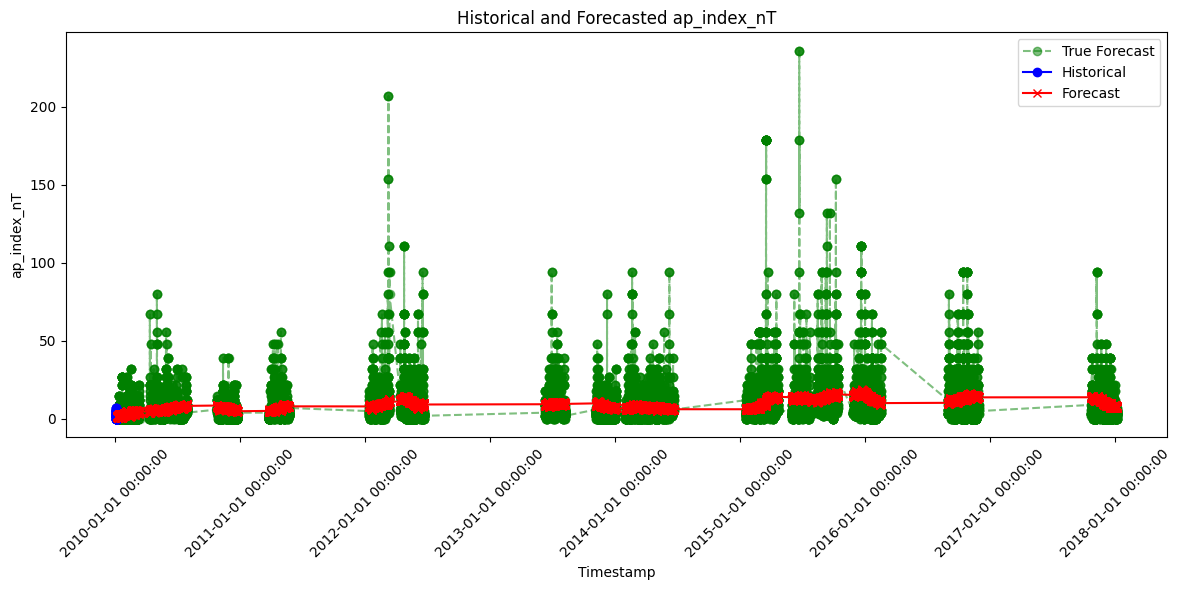

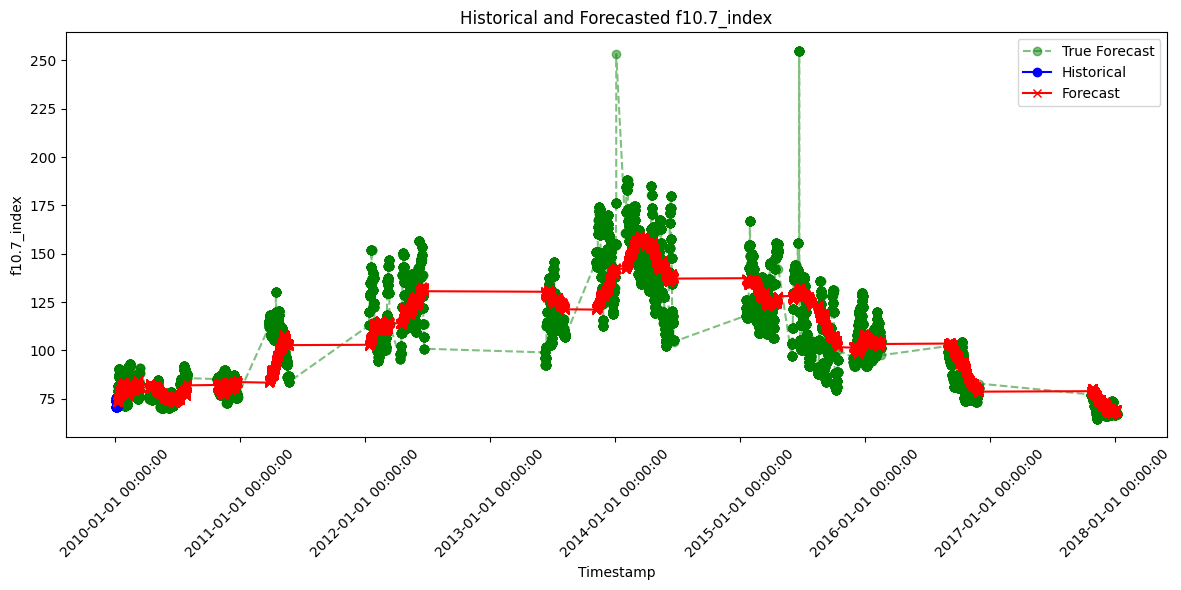

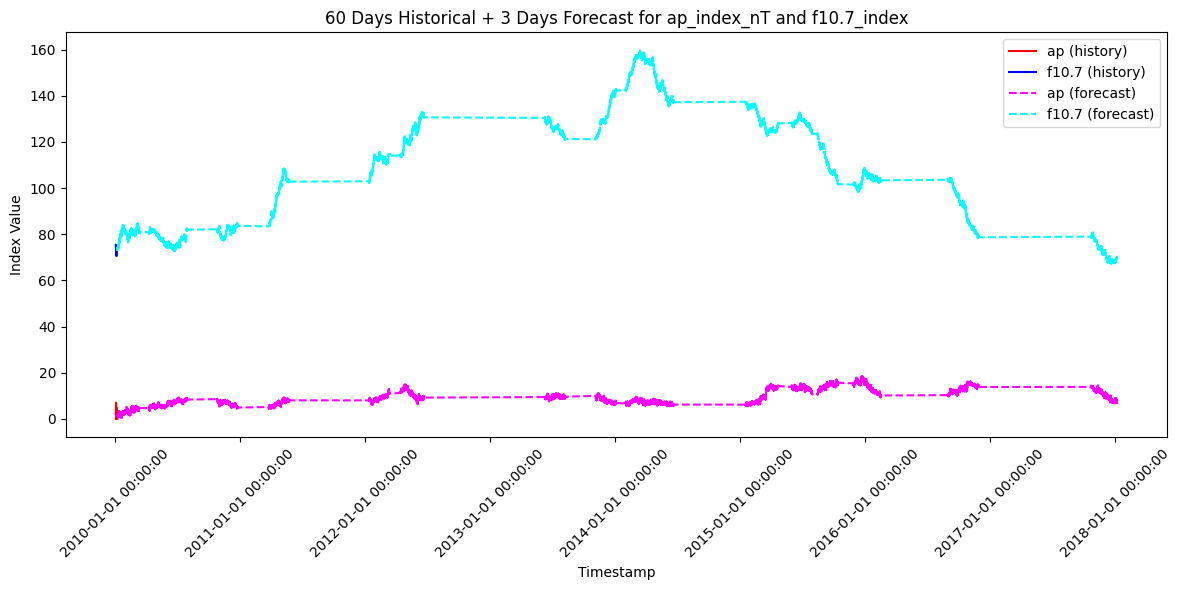

2025-02-17 01:55:50,713 - INFO - Plots generated.


In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_60_days_and_3_day_forecast(
    history_timestamps, history_ap, history_f107,
    forecast_timestamps, forecast_ap, forecast_f107
):
    """
    Plots 60 days of historical data for ap_index_nT (red) and f10.7_index (blue),
    plus 3 days of forecasted data (dashed lines) at satellite-density timestamps.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # --- Plot Historical Data ---
    ax.plot(history_timestamps, history_ap, color='red', label='ap (history)')
    ax.plot(history_timestamps, history_f107, color='blue', label='f10.7 (history)')

    # --- Plot Forecasted Data ---
    ax.plot(forecast_timestamps, forecast_ap, color='magenta', linestyle='--', label='ap (forecast)')
    ax.plot(forecast_timestamps, forecast_f107, color='cyan', linestyle='--', label='f10.7 (forecast)')

    # Format the x-axis to show full date + time
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.xticks(rotation=45)

    plt.xlabel("Timestamp")
    plt.ylabel("Index Value")
    plt.title("60 Days Historical + 3 Days Forecast for ap_index_nT and f10.7_index")
    plt.legend()
    plt.tight_layout()
    plt.show()

test_offset = split_idx - input_window - forecast_horizon + 1
sample_index = 0  # Choose the first test sample (change as needed)
global_index = test_offset + sample_index
logger.debug(f"Using global index {global_index} for forecast sample.")

history_timestamps = omni_df['Timestamp'].iloc[global_index : global_index + input_window].values
history_ap = omni_df['ap_index_nT'].iloc[global_index : global_index + input_window].values
history_f107 = omni_df['f10.7_index'].iloc[global_index : global_index + input_window].values

forecast_timestamps = omni_df['Timestamp'].iloc[global_index + input_window : global_index + input_window + forecast_horizon].values
true_forecast_ap = omni_df['ap_index_nT'].iloc[global_index + input_window : global_index + input_window + forecast_horizon].values
true_forecast_f107 = omni_df['f10.7_index'].iloc[global_index + input_window : global_index + input_window + forecast_horizon].values

# Run your model to get predictions
sample_x, _ = test_dataset[sample_index]
sample_x = sample_x.unsqueeze(0).to(device)
pred_sample = model(sample_x).cpu().detach().numpy().squeeze(0)
pred_ap = pred_sample[:, 0]
pred_f107 = pred_sample[:, 1]
logger.info("Forecast sample computed.")

# Plot the forecast for ap_index_nT.
plot_combined_forecast(history_timestamps, history_ap, forecast_timestamps, pred_ap,
                       ylabel="ap_index_nT", title="Historical and Forecasted ap_index_nT",
                       true_forecast=true_forecast_ap)

# Plot the forecast for f10.7_index.
plot_combined_forecast(history_timestamps, history_f107, forecast_timestamps, pred_f107,
                       ylabel="f10.7_index", title="Historical and Forecasted f10.7_index",
                       true_forecast=true_forecast_f107)

plot_60_days_and_3_day_forecast(
    history_timestamps, history_ap, history_f107,
    forecast_timestamps, pred_ap, pred_f107
)

logger.info("Plots generated.")

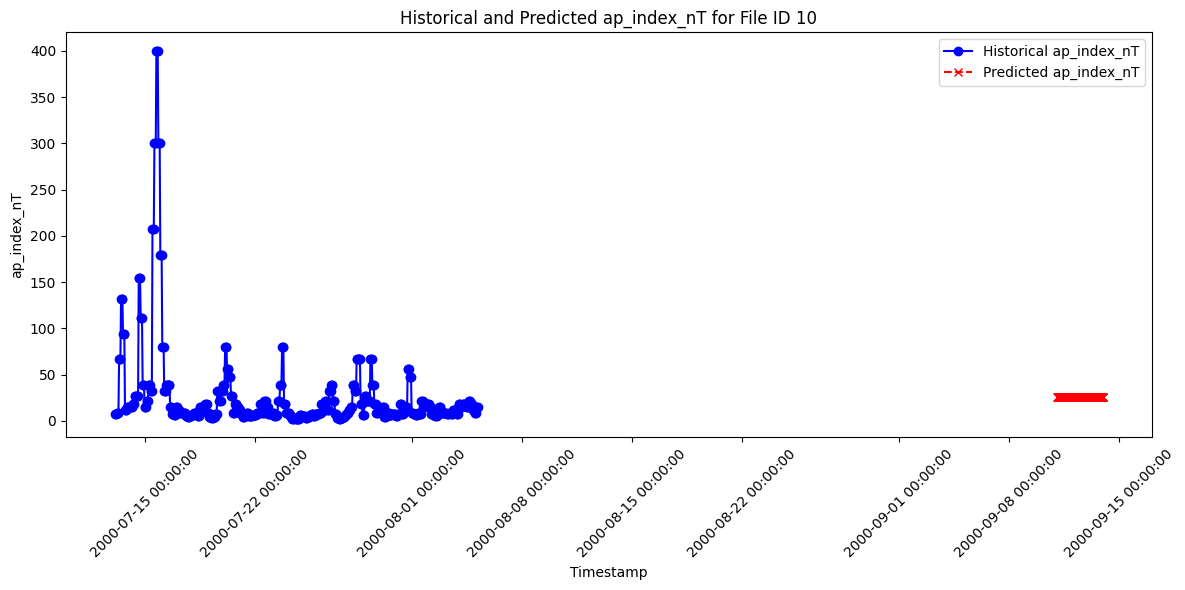

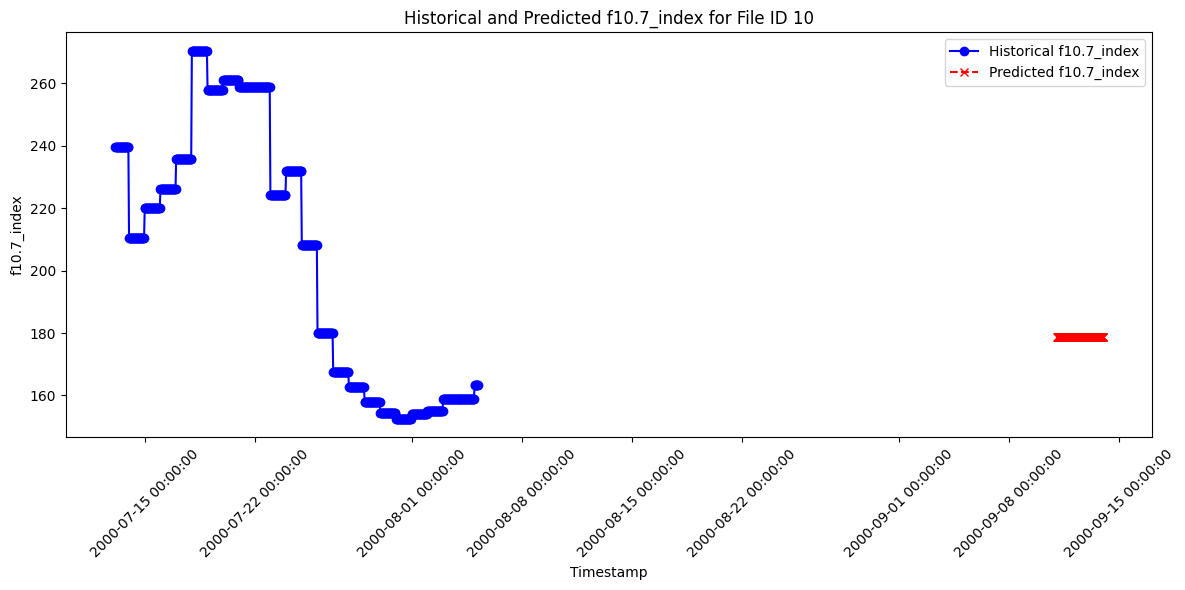

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_forecast_for_file(omni_df, predicted_sat_df, target, history_days=60):
    """
    Plots the historical values for a target from omni_df (for the 60 days preceding the
    forecast) and the predicted values from predicted_sat_df (at the sat density timestamps).

    Args:
        omni_df (DataFrame): The entire OMNI DataFrame (must have a 'Timestamp' column).
        predicted_sat_df (DataFrame): The sat density DataFrame for a single file_id,
            with columns "Timestamp", "{target}_pred".
        target (str): The target column name (e.g., "ap_index_nT" or "f10.7_index").
        history_days (int): Number of days (or time steps) of historical data to show.
            (Here we assume that the OMNI data has daily resolution.)
    """
    # Get the start time of the forecast period from the sat density file.
    forecast_start = predicted_sat_df["Timestamp"].min()
    
    # Define the historical period: the history_days immediately preceding the forecast.
    history_start = forecast_start - pd.Timedelta(days=history_days)
    
    # Filter the historical OMNI data.
    history_data = omni_df[(omni_df["Timestamp"] >= history_start) & (omni_df["Timestamp"] < forecast_start)]
    
    # Create the plot.
    plt.figure(figsize=(12, 6))
    plt.plot(history_data["Timestamp"], history_data[target], label="Historical " + target, color="blue", marker='o')
    plt.plot(predicted_sat_df["Timestamp"], predicted_sat_df[target + "_pred"], 
             label="Predicted " + target, color="red", linestyle="--", marker='x')
    
    plt.xlabel("Timestamp")
    plt.ylabel(target)
    plt.title(f"Historical and Predicted {target} for File ID {predicted_sat_df['File_ID'].iloc[0] if 'File_ID' in predicted_sat_df.columns else 'N/A'}")
    
    # Format the x-axis to show full timestamps including hour, minute, second.
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def predict_for_each_timestamp_in_sat_file(
    model,
    data_handler,
    file_id,
    omni_df,
    input_features,
    device,
    input_window=100
):
    """
    For a given file_id, read the satellite density timestamps.
    For each timestamp T in that file:
      1) Gather the preceding 'input_window' rows from omni_df (strictly before or up to T)
      2) Run a single-step forecast to get ap_index_nT and f10.7_index at time T
      3) Store the forecast in new columns (ap_index_nT_pred, f10.7_index_pred)

    Args:
        model: A trained PatchTST (or similar) model that expects input_window timesteps
               and outputs a single-step forecast (1, target_size).
        data_handler: Instance of DataHandler with .read_sat_density_data(file_id).
        file_id: The specific file ID whose sat density timestamps we want to forecast.
        omni_df: The entire OMNI DataFrame used for training (sorted by Timestamp).
        input_features: List of column names used as input features for the model.
        device: Torch device (e.g., 'cuda' or 'cpu').
        input_window: The model’s input window size.

    Returns:
        A DataFrame (the sat density file) with new columns:
          "ap_index_nT_pred" and "f10.7_index_pred"
        for each timestamp.
    """

    # 1) Read the satellite density file for the given file_id.
    sat_df = data_handler.read_sat_density_data(file_id).copy()
    sat_df["Timestamp"] = pd.to_datetime(sat_df["Timestamp"])
    sat_df.sort_values("Timestamp", inplace=True)
    sat_df.reset_index(drop=True, inplace=True)

    # Prepare columns to store predictions.
    ap_preds = []
    f107_preds = []

    # 2) For each timestamp in the satellite file, do a single-step forecast.
    for i, row in sat_df.iterrows():
        t = row["Timestamp"]
        # Gather the preceding input_window rows from omni_df
        # that are <= t in time.
        # (Ensure omni_df is sorted by Timestamp.)
        mask = (omni_df["Timestamp"] <= t)
        sub_omni = omni_df[mask].tail(input_window)

        # If not enough data to fill input_window, we can't forecast.
        # You can decide whether to skip or fill with NaN.
        if len(sub_omni) < input_window:
            ap_preds.append(np.nan)
            f107_preds.append(np.nan)
            continue

        # 3) Build the model input sequence from the sub_omni data
        input_seq = sub_omni[input_features].values  # shape: (input_window, len(input_features))

        # Run the model for a single-step forecast
        with torch.no_grad():
            input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
            # The model should output shape (1, 1, target_size) if it's single-step
            # or (1, forecast_horizon, target_size) if multi-step. Here we assume single-step:
            out = model(input_tensor)  # shape: (1, 1, target_size) or (1, forecast_horizon, target_size)
            out = out.detach().cpu().numpy().squeeze(0)  # shape: (1, target_size) or (forecast_horizon, target_size)

        # If your model is truly single-step, out now has shape (1, target_size).
        # If multi-step, you might do out = out[0, 0] or something similar.
        if len(out.shape) == 2 and out.shape[0] > 1:
            # Multi-step model => take only the first step
            out = out[0]

        ap_preds.append(out[0])     # ap_index_nT
        f107_preds.append(out[1])   # f10.7_index

    # 4) Store predictions in the sat_df
    sat_df["ap_index_nT_pred"] = ap_preds
    sat_df["f10.7_index_pred"] = f107_preds

    return sat_df
# -----------------------------
# Example usage:
# -----------------------------
# Assume you have already generated predicted_sat_df using your predict_for_each_timestamp_in_sat_file function.
# For instance:
file_id_to_forecast = 10  # change as needed

predicted_sat_df = predict_for_each_timestamp_in_sat_file(
    model=model,
    data_handler=data_handler,
    file_id=file_id_to_forecast,
    omni_df=omni_df,             # entire OMNI DF used for training
    input_features=['Vector_B_Magnitude_nT', 'Dst_index_nT', 'AL_index_nT', 'AU_index_nT', 
                    'SW_Plasma_Temperature_K', 'BY_nT_GSE', 'Scalar_B_nT', 'BZ_nT_GSE', 
                    'Lyman_alpha', 'AE_index_nT', 'SW_Plasma_Speed_km_s', 'Bartels_rotation_number', 
                    'Flow_pressure', 'R_Sunspot_No', 'SW_Proton_Density_N_cm3', 'Kp_index', 
                    'Plasma_Beta', 'BX_nT_GSE_GSM'],
    device=device,
    input_window=100
)

# Optionally, if your predicted_sat_df does not include a "File_ID" column, you can add it:
predicted_sat_df["File_ID"] = file_id_to_forecast

# Now, plot the two separate figures:
plot_forecast_for_file(omni_df, predicted_sat_df, target="ap_index_nT", history_days=60)
plot_forecast_for_file(omni_df, predicted_sat_df, target="f10.7_index", history_days=60)


## 8. Save Model and Generate Forecasted Sat Density Files

In this section, we will:
1. Save the trained PatchTST model to a file so it can be imported later.
2. Create a new folder (`data/sat_density_omni_forcasted`) for storing the forecasted sat density files.
3. For each file ID, we will:
   - Run our forecasting function (which uses the entire OMNI dataset to predict the `ap_index_nT` and `f10.7_index` at the sat density timestamps for that file).
   - Append the predicted values as new columns to a copy of the original sat density DataFrame.
   - Save the new DataFrame to the output folder.


In [15]:
# === Save the trained model ===
model_save_path = Path("./saved_models/patchtst_model.pth")
model_save_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_save_path)
logger.info(f"Model saved to {model_save_path}")

# === Create output folder for forecasted sat density files ===
output_folder = Path("./data/sat_density_omni_forcasted")
output_folder.mkdir(parents=True, exist_ok=True)
logger.info(f"Output folder created: {output_folder}")

# === Loop over each file_id and forecast ===
file_ids = data_handler.initial_states["File ID"].unique()
logger.info(f"Forecasting for {len(file_ids)} file IDs.")

for fid in file_ids:
    try:
        # Run the forecasting function for each file_id.
        # The function 'predict_for_each_timestamp_in_sat_file' should be defined elsewhere in your notebook.
        pred_df = predict_for_each_timestamp_in_sat_file(
            model=model,
            data_handler=data_handler,
            file_id=fid,
            omni_df=omni_df,             # Use the full OMNI DataFrame
            input_features=input_features,  # The candidate input features (as selected/cleaned earlier)
            device=device,
            input_window=100
        )
        # Save the predicted sat density file to the new folder.
        output_path = output_folder / f"sat_density_{fid:05d}.csv"
        pred_df.to_csv(output_path, index=False)
        logger.info(f"Saved forecasted file for File ID {fid} to {output_path}")
    except Exception as e:
        logger.error(f"Error forecasting for File ID {fid}: {e}")


2025-02-17 02:03:56,428 - INFO - Model saved to saved_models\patchtst_model.pth
2025-02-17 02:03:56,429 - INFO - Output folder created: data\sat_density_omni_forcasted
2025-02-17 02:03:56,431 - INFO - Forecasting for 8119 file IDs.
2025-02-17 02:03:57,390 - INFO - Saved forecasted file for File ID 0 to data\sat_density_omni_forcasted\sat_density_00000.csv
2025-02-17 02:03:58,168 - INFO - Saved forecasted file for File ID 1 to data\sat_density_omni_forcasted\sat_density_00001.csv
2025-02-17 02:03:58,961 - INFO - Saved forecasted file for File ID 2 to data\sat_density_omni_forcasted\sat_density_00002.csv
2025-02-17 02:03:59,735 - INFO - Saved forecasted file for File ID 3 to data\sat_density_omni_forcasted\sat_density_00003.csv
2025-02-17 02:04:00,602 - INFO - Saved forecasted file for File ID 4 to data\sat_density_omni_forcasted\sat_density_00004.csv
2025-02-17 02:04:01,244 - INFO - Saved forecasted file for File ID 5 to data\sat_density_omni_forcasted\sat_density_00005.csv
2025-02-17 0

KeyboardInterrupt: 

## Conclusion

In this notebook we:
- Loaded and preprocessed the OMNI and sat density data.
- Selected candidate features based on domain knowledge and cleaned them.
- Defined the PatchTST model and the dataset classes.
- Set up training, evaluation, and forecasting functions.
- (Optionally) Trained the model and evaluated its performance.
- Forecasted on a sample and plotted the historical and forecasted values.

Use the individual cells to debug and experiment without running the entire pipeline every time.
